## Qdrant Sparse DB

In [ ]:
import json

with open("chunks_fixed.json", "r") as f:
    chunks = json.load(f)

texts = [c["text"] for c in chunks]
ids = [c["id"] for c in chunks]

print("Loaded chunks:", len(chunks))


In [ ]:
from qdrant_client import QdrantClient, models
from fastembed import SparseTextEmbedding

#client = QdrantClient(path="qdrant_db")

sparse_embedder = SparseTextEmbedding("Qdrant/bm25")

In [ ]:
bm25_vectors = list(sparse_embedder.embed(texts))

In [ ]:
len(bm25_vectors), len(texts)

In [ ]:
collection_name = "deepseek_sparse_fixed"

if client.collection_exists(collection_name):
    client.delete_collection(collection_name)

client.create_collection(
    collection_name=collection_name,
    vectors_config={},
    sparse_vectors_config={
        "bm25": models.SparseVectorParams(
            modifier=models.Modifier.IDF
        )
    }
)

print("Collection created:", collection_name)

In [ ]:
points = []
for i in range(len(texts)):
    points.append(
        models.PointStruct(
            id=ids[i],
            vector={"bm25": bm25_vectors[i].as_object()},
            payload={"chunk_id": ids[i], "text": texts[i]}
        )
    )

client.upsert(
    collection_name="deepseek_sparse_fixed",
    points=points
)

print("Upsert completed!")

In [ ]:
query = "Which reinforcement learning algorithm does DeepSeek-R1 use?"
query_sparse = next(sparse_embedder.query_embed(query))

results = client.query_points(
    collection_name="deepseek_sparse_fixed",
    query=models.SparseVector(**query_sparse.as_object()),
    using="bm25",
    with_payload=True,
    limit=5
).points

## Build Graph

In [19]:
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    summary: str = ""

In [36]:
client = QdrantClient(path="qdrant_db")

In [20]:
from qdrant_client import QdrantClient, models
from fastembed import SparseTextEmbedding

# Load BM25 embedder & Qdrant client
sparse_embedder = SparseTextEmbedding("Qdrant/bm25")
#client = QdrantClient(path="qdrant_db")   # adjust path if needed

def retrieve(query: str, top_k: int = 5) -> str:
    """Sparse BM25 retrieval from Qdrant."""
    q_vec = next(sparse_embedder.query_embed(query))

    hits = client.query_points(
        collection_name="deepseek_sparse_fixed",  
        query=models.SparseVector(**q_vec.as_object()),
        using="bm25",
        limit=top_k,
        with_payload=True
    ).points

    if not hits:
        return "No relevant document found."

    return {
    "chunks": [
        {
            "chunk_id": hit.payload["chunk_id"],
            "text": hit.payload["text"]
        }
        for hit in hits
    ]
}

In [21]:
def rag_search(query: str) -> str:
    """Retrieve relevant DeepSeek-R1 chunks from Qdrant."""
    return retrieve(query)  


In [ ]:
from langchain_groq import ChatGroq
import os

llm = ChatGroq(model="llama-3.3-70b-versatile", groq_api_key="")

tools = [rag_search]

llm_with_tools = llm.bind_tools(tools)


In [29]:
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(content=
"""You are a DeepSeek-R1 expert assistant.
You have access to a retrieval tool 'rag_search'.

Rules:
- Use rag_search ONLY when user query requires referencing DeepSeek-R1 PDF.
- If not needed, answer directly.
- Incorporate conversation summary if available.
""")


def assistant(state: AgentState):

    messages = [sys_msg]

    # inject summary if exists
    summary = state.get("summary", "")
    if summary:
        messages.append(
            SystemMessage(content=f"Conversation summary:\n{summary}")
        )

    messages += state["messages"]

    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}



In [30]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

In [31]:
from langchain_core.messages import HumanMessage, RemoveMessage

def summarize(state: AgentState):

    prev_summary = state.get("summary", "")
    messages = state["messages"]

    if prev_summary:
        prompt = (
            f"This is the current summary:\n{prev_summary}\n\n"
            "Extend the summary using the new messages above."
        )
    else:
        prompt = "Create a summary of the conversation above."

    response = llm.invoke(messages + [HumanMessage(content=prompt)])

    new_summary = response.content

    # Keep the last 2 messages
    delete = [RemoveMessage(id=m.id) for m in messages[:-2]]

    return {"summary": new_summary, "messages": delete}



In [32]:
from typing_extensions import Literal
from langgraph.graph import END

def should_summarize(state: AgentState) -> Literal["summarize", END]:

    if len(state["messages"]) > 6:
        return "summarize"
    return END


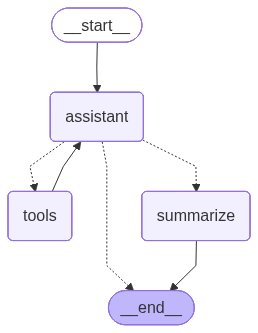

In [33]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

builder = StateGraph(AgentState)

builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)
builder.add_node("summarize", summarize)

# START → assistant
builder.add_edge(START, "assistant")

# assistant → tools (if tool call) OR END (if no tool)
builder.add_conditional_edges(
    "assistant",
    tools_condition,   
)

# tools → assistant (ReAct Loop)
builder.add_edge("tools", "assistant")

# assistant → summarize ? END ? (second routing rule)
builder.add_conditional_edges(
    "assistant",
    should_summarize  
)

# summarize → END
builder.add_edge("summarize", END)

# enable memory
memory = MemorySaver()
agent = builder.compile(checkpointer=memory)
display(Image(agent.get_graph().draw_mermaid_png()))

## Threads

In [34]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = agent.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = agent.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = agent.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lance, it's nice to meet you. Is there something I can help you with or would you like to chat?
================================== Ai Message ==================================

Your name is Lance. We just introduced ourselves a moment ago. Is there something else you'd like to talk about or ask?
================================== Ai Message ==================================

That's great, Lance! It sounds like you're a fan of the San Francisco 49ers, a professional American football team. Do you have a favorite player or memory associated with the team?


In [37]:
input_message = HumanMessage(content="How does DeepSeek-R1-Zero use reinforcement learning?")
output = agent.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

DeepSeek-R1-Zero uses reinforcement learning (RL) to improve its reasoning capabilities. The model is trained via large-scale RL without supervised fine-tuning (SFT) as a preliminary step, and it demonstrates remarkable reasoning capabilities. Through RL, DeepSeek-R1-Zero naturally emerges with numerous powerful and intriguing reasoning behaviors. However, it encounters challenges such as poor readability and language mixing. To address these issues and further enhance reasoning performance, DeepSeek-R1 is introduced, which applies RL starting from a checkpoint fine-tuned with thousands of long Chain-of-Thought (CoT) examples.
